# 7. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [186]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [187]:
categories = ['alt.atheism','comp.graphics',\
               'sci.space','talk.religion.misc']

In [188]:
data = fetch_20newsgroups(subset='all',
    categories=categories, remove=('headers', 'footers', 'quotes'))#, shuffle=True, random_state=42)

In [189]:
data.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Выведите по 1 тексту для каждой из категории.

In [190]:
import pandas as pd

In [191]:
def to_dataframe(data):

    df = pd.DataFrame([data.data, data.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(data.target_names)
    targets.columns=['category']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    return out

In [192]:
df = to_dataframe(data)

In [193]:
df.head()

,text,target,category
0,My point is that you set up your views as the ...,0,alt.atheism
9,"\n]The ""corrupted over and over"" theory is pr...",0,alt.atheism
14,"\n\nBut, you wouldn't know what red *was*, and...",0,alt.atheism
26,\n\nWell I agree with you in the sense that th...,0,alt.atheism
27,"\n\nSpecifically, which changes are you talkin...",0,alt.atheism


In [194]:
for cat in df.category.unique():
    row = df[df['category']==cat].head(1)
    print('Category({}): {}\n'.format(row['target'][:1].values[0],cat))  
    print(row['text'][:1].values[0])
    print('-----------------')

Category(0): alt.atheism

My point is that you set up your views as the only way to believe.  Saying 
that all eveil in this world is caused by atheism is ridiculous and 
counterproductive to dialogue in this newsgroups.  I see in your posts a 
spirit of condemnation of the atheists in this newsgroup bacause they don'
t believe exactly as you do.  If you're here to try to convert the atheists 
here, you're failing miserably.  Who wants to be in position of constantly 
defending themselves agaist insulting attacks, like you seem to like to do?!
I'm sorry you're so blind that you didn't get the messgae in the quote, 
everyone else has seemed to.
-----------------
Category(1): comp.graphics


By '8 grey level images' you mean 8 items of 1bit images?
It does work(!), but it doesn't work if you have more than 1bit
in your screen and if the screen intensity is non-linear.

With 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,
this gives 16 levels, but they are linear if screen intensity

### 2.2 Мешок слов (6 баллов)

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [195]:
from sklearn.feature_extraction.text import CountVectorizer

In [241]:
X = df['text']
y = df['target'].astype('int')

?? Векторизацию лучше выполнять на тетстовых данных?

??? Если в новых данных окажутся слова, которых не было в данных на которых происходило обучение, то в векторе для этого слова будет 0. Нужно ли добавлять новые слова в словарь? Иммет ли это смысл, если при обучении, в тренеровочных данных все равно этого слова нет?

In [249]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.7, stratify=y)

In [250]:
vectorizer = CountVectorizer(stop_words='english')
#X_vector = vectorizer.fit_transform(X)
X_train = vectorizer.fit_transform(X_train_orig)
X_test = vectorizer.transform(X_test_orig)

In [252]:
print("Количество слов в словаре: ", len(vectorizer.vocabulary_))
X_train.shape

Количество слов в словаре:  16664


(1016, 16664)

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [199]:
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

In [200]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [201]:
import numpy as np
import matplotlib.pyplot as plt

? Верно, что лучшие гиперпарамеры мы подбираем на тренеровочной выборке а не на всей?

In [253]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_train, y_train)

CPU times: user 216 ms, sys: 83.4 ms, total: 299 ms
Wall time: 1.54 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [254]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7716507292572201, params={'alpha': 3}


In [255]:
clf = MultinomialNB(alpha=3)
clf.fit(X_train, y_train)

MultinomialNB(alpha=3, class_prior=None, fit_prior=True)

In [256]:
y_pred = clf.predict(X_test)

In [257]:
class_names = df.groupby(['target','category']).count().reset_index().category.values

Как проверить, что лейблы выставлены правильно? Можно взять количество значений по группам в y_test, просуммировать значения по горизонтали, тем самым определив индекс метки, затем по индексу сравнить с df.  

сумма в 592 в матрице это 3 строка, лейбл sci.space, индекс в y_test с 592 == 2, что соответствует sci.space из df

In [258]:
y_test.value_counts()

2    691
1    681
0    559
3    440
Name: target, dtype: int64

In [259]:
df.groupby(['target','category']).count()

,,text
target,category,
0,alt.atheism,799
1,comp.graphics,973
2,sci.space,987
3,talk.religion.misc,628


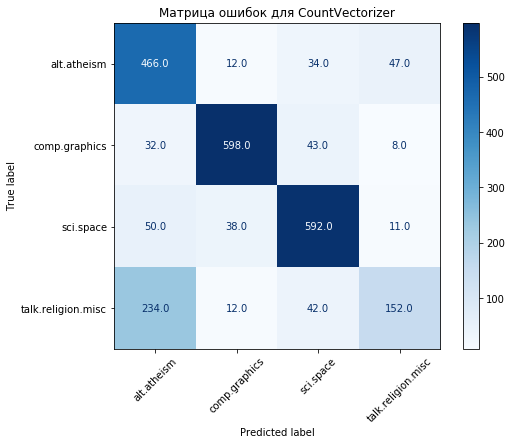

In [260]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=1)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для CountVectorizer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [261]:
print(classification_report(y_test, y_pred, target_names=class_names))

                    precision    recall  f1-score   support

       alt.atheism       0.60      0.83      0.70       559
     comp.graphics       0.91      0.88      0.89       681
         sci.space       0.83      0.86      0.84       691
talk.religion.misc       0.70      0.35      0.46       440

          accuracy                           0.76      2371
         macro avg       0.76      0.73      0.72      2371
      weighted avg       0.77      0.76      0.75      2371



In [262]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

In [263]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [say atheists think just atheism does don people jesus god]
comp.graphics: [format use color files bit gif graphics file image jpeg]
sci.space: [earth just moon orbit time satellite nasa like launch space]
talk.religion.misc: [does like say know did don just jesus god people]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (6 баллов) 

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

??? На сколько важно знать эти формулы в отличии от слепого использования функций sklearn? Спрашивают ли это на собеседовании? Что важнее, написать формулу и реализовать ее "руками" или знать нужную(ые) готовые функции?

In [264]:
from sklearn.feature_extraction.text import TfidfTransformer

In [265]:
tfidf_transformer = TfidfTransformer()

In [216]:
## Тестирование

In [217]:
docs_new = ['God love', 'dad love']
docs_test = ['God llove']

In [218]:
vectorizer_t = CountVectorizer(stop_words='english')
X_new_counts = vectorizer_t.fit_transform(docs_new)

In [219]:
vectorizer_t.vocabulary_

{'god': 1, 'love': 2, 'dad': 0}

In [220]:
X_new_counts.toarray()

array([[0, 1, 1],
       [1, 0, 1]])

In [221]:
X_test_counts = vectorizer_t.transform(docs_test)
X_test_counts.toarray()

array([[0, 1, 0]])

In [222]:
X_new_counts_tfidf = tfidf_transformer.fit_transform(X_new_counts)

In [223]:
X_new_counts_tfidf.toarray()

array([[0. , 0.8, 0.6],
       [0.8, 0. , 0.6]])

In [224]:
##--# Тестирование

??? Тут нужно разобраться как правильно обучать, на трейне или на всех данных?

https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest  
https://stats.stackexchange.com/questions/344571/imputing-the-mean-value-from-the-train-set-into-the-test-set

In [266]:
X_tfidf_train = tfidf_transformer.fit_transform(X_train)
#X_tfidf_test = tfidf_transformer.fit_transform(X_test)
X_tfidf_test = tfidf_transformer.transform(X_test)

In [267]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_tfidf_train, y_train)

CPU times: user 152 ms, sys: 20.2 ms, total: 172 ms
Wall time: 252 ms


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [268]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7401477832512315, params={'alpha': 1}


In [269]:
clf = MultinomialNB(alpha=1)
clf.fit(X_tfidf_train, y_train)

y_pred_tfidf = clf.predict(X_tfidf_test)

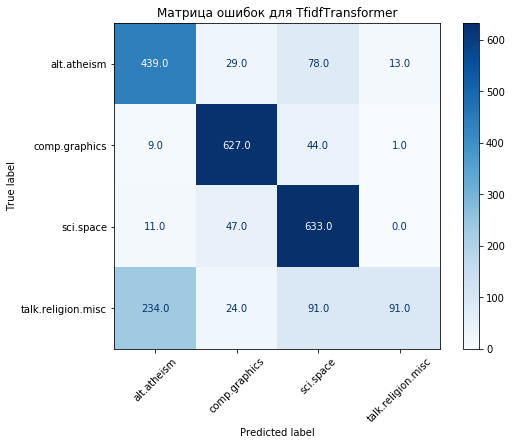

In [270]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=1)
disp = plot_confusion_matrix(clf, X_tfidf_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для TfidfTransformer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [272]:
print(classification_report(y_test, y_pred_tfidf, target_names=class_names))

                    precision    recall  f1-score   support

       alt.atheism       0.63      0.79      0.70       559
     comp.graphics       0.86      0.92      0.89       681
         sci.space       0.75      0.92      0.82       691
talk.religion.misc       0.87      0.21      0.33       440

          accuracy                           0.75      2371
         macro avg       0.78      0.71      0.69      2371
      weighted avg       0.78      0.75      0.72      2371



??? Качество ухудшилось, нужно разбираться почему

In [232]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [atheism islam does say religion just people don think god]
comp.graphics: [need software know looking program files image thanks file graphics]
sci.space: [sky think just launch shuttle orbit moon like nasa space]
talk.religion.misc: [believe christian did bible know just don people jesus god]


In [283]:
#Слова и их веса
def token_weight_df (dic, prefix):    
    token_weight = pd.DataFrame.from_dict(dic, orient='index').reset_index()
    token_weight.columns=(prefix,'weight_'+prefix)
    token_weight = token_weight.sort_values(by='weight_'+prefix, ascending=False)
    return token_weight

In [284]:
#объединение слов и весов
rr = dict(zip(vectorizer.get_feature_names(), tfidf_transformer.idf_))

In [285]:
rr_voc = token_weight_df(rr,'rr')

In [286]:
rr_voc.head()

,rr,weight_rr
16663,zyda,7.231465
8382,jimi,7.231465
15102,tif,7.231465
8374,jfc,7.231465
8375,jfelder,7.231465


### 2.4 В чём проблема? (7 баллов)

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

![](https://i.imgur.com/3D5pgrk.png)

Ответ: Основные "проблемы" с реглигией, во первых атеизм входит в понятие религии, во вторых почему то при определении космоса и графики часть путается с религией, при этом религия не путается с космосом и графикой. Это вероятно говорит о том, что в категории религии специфичные слова имеют больший вес, точнее описывают категории, в отличии от космоса, где проскальзывают слова из религии с весом далеко не на дне. Показательно TN для реглигии и атеизма, вероятно всего это связано с общими/одинаковыми словами в этих темах, поэтому классификатору сложно их различать. В целом у темы космоса и графики отличные показатели полноты, точность немного страдает, но если "разобраться" с религией, то думаю станет лучше. Конечно со словарем никак не работали, нужно убирать все цифры и общие слова во всех темах,  а так же проводить анализ словарей по категорям, особенно смотреть на топовые слова. Например из космоса можно убрать слова (think just like) и прочие подобные слова убрать вообще из всех категорий. Из атеизма можно убрать (god, religion), оставим только для религии.

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.

### Дополнительная работа

##### "НЕ слова"

В словаре много "мусора" (цифры, прочерки и т.д.), нужно его убрать:

In [273]:
vectorizer.get_feature_names()

['00',
 '000',
 '00000',
 '0001',
 '0004244402',
 '00043819',
 '0004988',
 '0049',
 '006',
 '0098',
 '01',
 '01272',
 '013846',
 '01readme',
 '02',
 '0200',
 '02115',
 '0223',
 '023220',
 '0238',
 '024',
 '03',
 '0300',
 '03051',
 '04',
 '04g',
 '05',
 '06',
 '060',
 '06487',
 '0674',
 '068',
 '07',
 '070156',
 '074502',
 '0773',
 '08',
 '08240',
 '09',
 '0997',
 '0m',
 '0x0',
 '0xb00003',
 '10',
 '100',
 '1000',
 '100000',
 '10019',
 '10020',
 '10022',
 '10023',
 '10036',
 '100g',
 '100nm',
 '101',
 '101010',
 '102',
 '1024',
 '1024x768',
 '1024x768x24',
 '10281',
 '104',
 '1044',
 '105',
 '105366',
 '1059',
 '1066',
 '1070',
 '108',
 '1080',
 '109',
 '10940',
 '10fps',
 '10km',
 '11',
 '110',
 '111',
 '112',
 '114',
 '11425',
 '11432',
 '1145040',
 '115',
 '1150',
 '117',
 '1174',
 '12',
 '120',
 '1200',
 '1207',
 '1212',
 '121624',
 '12180',
 '12195',
 '1220',
 '122356',
 '123',
 '1231',
 '1234',
 '1238',
 '125',
 '125750',
 '127',
 '1278',
 '128',
 '1280',
 '129',
 '13',
 '130',
 '

In [291]:
import re

In [306]:
#слова на латинице от 3х букв
def GetEnWords (txt):  
    en_words = re.findall(r'\b[a-z]{3,}\b',re.sub(r'[a-z]{2,}\.+[a-z]*\b','',str(txt))) #слова на латинице от 3х букв    
    return ' '.join(en_words)

Сформирую новый столбец с текстом, который будет содержать только слова, затем на основе него составлю новый словарь.

In [307]:
df['text_f3'] = df['text'].apply(lambda r: GetEnWords(r))

In [309]:
df[['text','text_f3']].head()

,text,text_f3
0,My point is that you set up your views as the ...,point that you set your views the only way bel...
9,"\n]The ""corrupted over and over"" theory is pr...",corrupted over and over theory pretty weak the...
14,"\n\nBut, you wouldn't know what red *was*, and...",you wouldn know what red was and you certainly...
26,\n\nWell I agree with you in the sense that th...,agree with you the sense that they have moral ...
27,"\n\nSpecifically, which changes are you talkin...",which changes are you talking about you arguin...


In [310]:
X = df['text_f3']
y = df['target'].astype('int')

In [311]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.7, stratify=y)

In [312]:
vectorizer_f3 = CountVectorizer(stop_words='english')
X_train_f3 = vectorizer_f3.fit_transform(X_train_orig)
X_test_f3 = vectorizer_f3.transform(X_test_orig)

In [313]:
vectorizer_f3.get_feature_names()

['aaroundpluto',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandons',
 'abbreviation',
 'abducted',
 'abel',
 'aberration',
 'abhor',
 'abhorrence',
 'abiding',
 'abilities',
 'ability',
 'abiliy',
 'abilty',
 'abiogenesis',
 'ablazing',
 'able',
 'ablutions',
 'aboard',
 'abode',
 'abolitionist',
 'abominable',
 'abomination',
 'abominations',
 'abord',
 'abort',
 'abortion',
 'abortions',
 'abounded',
 'abruptly',
 'absence',
 'absense',
 'absent',
 'absolute',
 'absolutely',
 'absolutes',
 'absolutist',
 'absorb',
 'absorbed',
 'absorbtion',
 'absorption',
 'abstact',
 'abstinence',
 'abstract',
 'abstractions',
 'absurd',
 'absurdity',
 'absurdly',
 'abundantly',
 'abuse',
 'abused',
 'abuses',
 'abyss',
 'academia',
 'academic',
 'acadmic',
 'acceleration',
 'accelerations',
 'accelerator',
 'accelerators',
 'accelleration',
 'accept',
 'acceptable',
 'acceptably',
 'acceptance',
 'accepted',
 'accepting',
 'accesloration',
 'access',
 'accessed',
 'accessible',
 'accessi

In [314]:
print('Слов в словаре до очистке от мусора: {}'.format(len(vectorizer.get_feature_names())))
print('Слов в словаре после очистке от мусора: {}'.format(len(vectorizer_f3.get_feature_names())))

Слов в словаре до очистке от мусора: 16664
Слов в словаре после очистке от мусора: 11710


In [316]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7273592195498889, params={'alpha': 2}


In [317]:
clf = MultinomialNB(alpha=2)
clf.fit(X_train_f3, y_train)

MultinomialNB(alpha=2, class_prior=None, fit_prior=True)

In [318]:
y_pred = clf.predict(X_test_f3)

In [320]:
print(classification_report(y_test, y_pred, target_names=class_names))

                    precision    recall  f1-score   support

       alt.atheism       0.56      0.79      0.66       559
     comp.graphics       0.85      0.84      0.85       681
         sci.space       0.78      0.80      0.79       691
talk.religion.misc       0.64      0.29      0.40       440

          accuracy                           0.72      2371
         macro avg       0.71      0.68      0.67      2371
      weighted avg       0.72      0.72      0.70      2371



In [329]:
show_top10(clf, vectorizer_f3, class_names)

alt.atheism: [like time believe atheists just say don does think people]
comp.graphics: [like images format use color files graphics bit file image]
sci.space: [know year don satellite just time orbit like launch space]
talk.religion.misc: [good does did like know believe say just don people]


In [275]:
#объединение слов и весов
rr = dict(zip(vectorizer.get_feature_names(), tfidf_transformer.idf_))

In [278]:
#Слова и их веса
def token_weight_df (dic, prefix):    
    token_weight = pd.DataFrame.from_dict(dic, orient='index').reset_index()
    token_weight.columns=(prefix,'weight_'+prefix)
    token_weight = token_weight.sort_values(by='weight_'+prefix, ascending=False)
    return token_weight

In [279]:
rr_voc = token_weight_df(rr,'rr')

In [280]:
rr_voc.head(10)

,rr,weight_rr
16663,zyda,7.231465
8382,jimi,7.231465
15102,tif,7.231465
8374,jfc,7.231465
8375,jfelder,7.231465
8377,jgr,7.231465
8378,jhu,7.231465
8379,jijnasa,7.231465
8380,jila,7.231465
15101,tielens,7.231465


In [281]:
rr_voc.tail(10)

,rr,weight_rr
16215,way,3.041810
6825,good,2.954799
15116,time,2.862017
11123,people,2.849439
5007,does,2.824746
15024,think,2.812625
8653,know,2.591894
8499,just,2.535541
5028,don,2.495267
8990,like,2.486533


Попробую понять чем космос пересекается с религией и убрать эти слова из какой-то категории  
Сделаю отдельные словари на каждую категорию, затем попробую их почистить и затем объединить все в один словарь

In [181]:
vectorizer_space = CountVectorizer(stop_words='english')
X_vector_space = vectorizer_space.fit_transform(df[df.target == 2]['text'].head(1))

In [182]:
vectorizer_space.vocabulary_

{'did': 1,
 'rollout': 8,
 'going': 3,
 'pay': 7,
 'attention': 0,
 'news': 5,
 'gifs': 2,
 'headed': 4,
 'wuarchive': 9,
 'patrick': 6}

In [183]:
vectorizer_space.get_feature_names()

['attention',
 'did',
 'gifs',
 'going',
 'headed',
 'news',
 'patrick',
 'pay',
 'rollout',
 'wuarchive']